# Policy Gradients with Baseline: DOOM

In this notebook, we will create a Policy Gradient based agent that tries to survive in an hostile environement by collecting health.
<br>
We will use Policy Gradient with Baseline method <b>which is an approach to design the policy gradient algorithm</b>

Our agent after 400 epochs:
<img src="assets/doomhealth.gif" alt="Doom plays"/>
<br> 
## Aknowledgements
Our implementation will be inspired by this tutorial:
https://www.oreilly.com/ideas/reinforcement-learning-with-tensorflow

## A recap: Reinforcement Learning Process 🎮

<img src="assets/rl.png" alt="Reinforcement Learning process"/>

Reinforcement Learning: is when an agent learns by interacting with the environement itself (through trial and error) it receives reward when performing correct actions. It's a decision making problem.

<br>
The Reinforcement Learning loop:

- Agent receive state S0 from the environment
- Based on that state S0 agent take an action A0
- Environnement transitions to a new state S1
- Give some reward R1 to the agent
<br>
<br>
→ This output a sequence of state, reward and action.<br>
→ The goal of the agent <b>is maximize expected cumulative reward in order to reach an optimal policy (way to behave).</b>

### Recap: What is policy gradient? 🤖

- Policy Gradient is a policy based reinforcement learning method: in this method, we want <b>to directly to learn an π* by optimize it without worrying about a value function, we’ll directly parameterize the π and do gradient descent into a direction that improves it.</b>
<br><br>
- Why? Because it's sometimes easier to approximate than the value function. Also, we need a parameterized policy to deal with continuous action spaces and environments where we need to act stochastically.
<br><br>
- Common choices for the policy function: Softmax for discrete actions, Gaussian parameters for continuous actions.
<br><br>
- To measure the quality of π, we calculate the objective/score function `J(theta)` : we can use 3 differents methods: start value, average value, or average reward per time step. In our case by calculating the maximum expected cumulative reward (we can use the start value : use the mean of the return from the first time step (G1) == cumulative discounted reward for the entire episode).
<br>
<img style="width: 400px;" src="assets/objective.png" alt="Objective function"/>
<br>
<br>
- Then, we have an objective function. Now, we want to find a π that max it. We Using gradient ascent by computing the gradients analytically: Policy Gradient Theorem: `grad(J(theta)) = Ex[grad(log(pi(s, a))) * Q(s, a)]`. Basically, we move our policy into a direction of more reward.
<br>
<img style="width: 600px;" src="assets/policygrad.png" alt="Policy gradients"/>
<br>
<br>
- REINFORCE (Monte Carlo Policy Gradient): We substitute a samples return `g_t` form an episode for Q(s, a) to make an update. Unbiased but high variance.
<img src="assets/montecarlo.png" alt="Monte Carlo"/>
<br><br>
    For each episode:
        At each time step within that episode:
            Compute the log probabilities produced by our policy function.
            Multiply it by the score function.
            Update the weights with some small learning rate alpha
<br>    <br>     


## Policy Gradients with Baseline method 👾
- Baseline: Instead of measuring the absolute goodness of an action we want to know how much better than "average" it is to take an action given a state. E.g. some states are naturally bad and always give negative reward. This is called the advantage and is defined as `Q(s, a) - V(s)`. We use that for our policy update, e.g. `g_t - V(s)` for REINFORCE.

# Let's implement our Policy Based Agent 🕹️

<img src="assets/doom.gif" alt="Doom game"/>
Environement:
- The player is standing on top of acid water.
- He needs to learn how to navigate and <b>collect health packs to stay alive</b>.

In [1]:
# Taken from Udacity face generator project
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Libraries 📚

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from vizdoom import *
import skimage
from skimage import transform

### Preprocessing functions ⚙️
We have 2 preprocessing functions:
- discount: discount rewards and normalize them. This function evaluates a set of rewards from an episode + add normalization to our discounted rewards to make sure our reward range stays small.
- preprocess_frame: gray and resize our frame to 84x84x1

In [3]:
def discount(r, gamma, normal):
    discount = np.zeros_like(r)
    G = 0.0
    for i in reversed(range(0, len(r))):
        G = G * gamma + r[i]
        discount[i] = G
    # Normalize 
    if normal:
        mean = np.mean(discount)
        std = np.std(discount)
        discount = (discount - mean) / (std)
    return discount

"""# Preprocess the frame
## Reshape function:
# Processes Doom screen image to produce cropped and resized image. 
def preprocess_frame(frame):
    s = frame[10:-10,30:-30]
    s = scipy.misc.imresize(s,[84,84])
    s = np.reshape(s,[np.prod(s.shape)]) / 255.0
    return s
"""
def preprocess_frame(frame):
    # Greyscale Frame
    x = np.mean(frame,-1)
    # Normalize Pixel Values
    x = x/255
    x = transform.resize(x, [84,84])
    return(x)

### Environement 🎮
We use vizdoom that simulate a doom-like game

In [4]:
game = DoomGame()
game.load_config("health_gathering.cfg")
game.set_doom_scenario_path("health_gathering.wad")
game.set_window_visible(False)
game.init()
#actions_list = [[1,0,0], [0,1,0], [0,0,1]]
actions_list  = np.identity(3,dtype=bool).tolist()
print(actions_list)
render = False
folder_num = 0

[[True, False, False], [False, True, False], [False, False, True]]


### Hyperparameters 📊

In [5]:
## Model hyperparameters
action_size = 3
kernel = 8
strides = 2
padding = "VALID"

## Tune hyperparameters
lr = 1e-4
gamma = 0.99 # Discount rate
normalize_reward = True

value_scale = 0.5
entropy_scale = 0.00
gradient_clip = 40

## Folders
save_path="./models/healthGather.ckpt" # Place to save our model
episode_path = "./episodes/"

## Training
num_epochs = 1000
batch_size = 8000

### Neural Network 🧠
- Takes as input a state frame.
    - Implies preprocess the frame
- Output a probability distribution

We need as hyperparameters:
- action size = nb of probabilities
- kernel
- strides
- padding

In [6]:
# Our placeholders
# Our frame is 84x84x1
x = tf.placeholder(tf.float32, (None,84,84,1), name="inputs")
y = tf.placeholder(tf.int32, (None,), name="actions")
# Compute the one hot vectors for each action given
actions_onehot = tf.one_hot(y ,action_size,dtype=tf.int32)
r = tf.placeholder(tf.float32, (None,), name='reward')
n = tf.placeholder(tf.float32, (None), name='episodes')
d_r = tf.placeholder(tf.float32, (None,), name='discounted_reward')

In [7]:
# POLICY NETWORK
# Input is 128*128*1
conv1 = tf.layers.conv2d(inputs = x,
                                 filters = 16,
                                 kernel_size = [8,8],
                                 strides = 4,
                                 padding = padding,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                 name = "conv1")
        
conv1_batchnorm = tf.layers.batch_normalization(conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')

conv1_out = tf.nn.elu(conv1_batchnorm, name="conv1_out")

        
conv2 = tf.layers.conv2d(inputs = conv1_out,
                                 filters = 32,
                                 kernel_size = [8,8],
                                 strides = 4,
                                 padding = padding,
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                 name = "conv2")
        
conv2_batchnorm = tf.layers.batch_normalization(conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')

conv2_out = tf.nn.elu(conv2_batchnorm, name="conv2_out")

flatten = tf.layers.flatten(conv2_out)

fc1 = tf.layers.dense(inputs = flatten,
                                  units = 256,
                                  activation = tf.nn.elu,
                                name="fc1")


logits = tf.layers.dense(inputs = fc1,
                                  units = action_size,
                                  activation = None,
                        name = "logits")

value = tf.layers.dense(
        inputs=fc1, 
        units = 1, 
        name='value')
        
calc_action = tf.multinomial(logits, 1)
aprob = tf.nn.softmax(logits)
action_logprob = tf.nn.log_softmax(logits)

In [8]:
tf.trainable_variables()

[<tf.Variable 'conv1/kernel:0' shape=(8, 8, 1, 16) dtype=float32_ref>,
 <tf.Variable 'conv1/bias:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'batch_norm1/gamma:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'batch_norm1/beta:0' shape=(16,) dtype=float32_ref>,
 <tf.Variable 'conv2/kernel:0' shape=(8, 8, 16, 32) dtype=float32_ref>,
 <tf.Variable 'conv2/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'batch_norm2/gamma:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'batch_norm2/beta:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'fc1/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'fc1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'logits/kernel:0' shape=(256, 3) dtype=float32_ref>,
 <tf.Variable 'logits/bias:0' shape=(3,) dtype=float32_ref>,
 <tf.Variable 'value/kernel:0' shape=(256, 1) dtype=float32_ref>,
 <tf.Variable 'value/bias:0' shape=(1,) dtype=float32_ref>]

### Losses and gradients ⛰️

#### Policy Gradient Loss
- We defined an objective function  as <b> total reward an agent can achieve under policy π averaged over all starting states </b>:

In [9]:
%%latex
\begin{align}
J(\theta) = E_{\pi} [G_{1}]
\end{align}

<IPython.core.display.Latex object>

We also know that a gradient of this function is determined by policy gradient theorem as:
<img src="assets/pg.png" alt="pg"/>

We’re trying to maximize the J function so we can just say that:

In [10]:
%%latex
\begin{align}
L_{\pi} = - J(\theta)
\end{align}

<IPython.core.display.Latex object>

The final loss function is then:

In [11]:
%%latex
\begin{align}
L_{\pi} = -1/n \sum_{i=1}^{n} A(s_{i}, a_{i}) * log\pi(a_{i} | s_{i}) 
\end{align}

<IPython.core.display.Latex object>

Where: 
- -1/n sum : tf.reduce_mean
- A(si,ai): (d_r - value)
- logpi(ai|si): tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y) calculates the softmax and log loss


tf.reduce_mean([[3.,4], [5.,6], [6.,7]]) <br>
--> [ 3.5  5.5  6.5] <br>
--> Mean between element <br>

In [12]:
policyGradient_loss = tf.reduce_mean((d_r - value) * tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels=actions_onehot))

#### Value loss
Calculate our value loss by using common squared mean error loss:

In [13]:
value_loss = value_scale * tf.reduce_mean(tf.square(d_r - value))

#### Total loss

In [14]:
entropy_loss = -entropy_scale * tf.reduce_sum(aprob * tf.exp(aprob))
loss = policyGradient_loss + value_loss - entropy_loss

#### Optimizer and gradients

In [15]:
avg_reward = tf.divide(tf.reduce_sum(r), n)

optimizer = tf.train.AdamOptimizer(lr)
gradients = tf.gradients(loss, tf.trainable_variables())
gradients, _ = tf.clip_by_global_norm(gradients, gradient_clip) # gradient clipping
gradients_and_variables = list(zip(gradients, tf.trainable_variables()))
train_op = optimizer.apply_gradients(gradients_and_variables)

# Initialize Session
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Training ⏲️
#### Rollout function
This function will gather a batch of training data from multiple episodes.

In [16]:
def rollout(batch_size, render, folder_num):
    states, actions, rewards, rewardsFeed, discountedRewards = [], [], [], [], []
    episode_num  = 0
    # Launch a new episode
    game.new_episode("episodes/" + str(folder_num) + "_rec.lmp")
    state = game.get_state().screen_buffer
    state = preprocess_frame(state)
    
    
    ### ???
    action_repeat = 3
    reward = 0
    
    while True:
        # Run State Through Policy & Calculate Action
        state = state.reshape(1, 84, 84, 1)
        feed = {x: state}
        action = sess.run(calc_action, feed_dict=feed)
        action = action[0][0]
        
        # Perform action
        for i in range(action_repeat):
            new_reward = game.make_action(actions_list[action])
            done = game.is_episode_finished()
            if done:
                break
                
            reward += new_reward
            new_state = game.get_state().screen_buffer
            
            
        
        # Store results
        states.append(state)
        rewards.append(reward)
        actions.append(action) 
        
        # Update Current State
        reward = 0
        state = preprocess_frame(new_state)
        if done:
            # Track Discounted Rewards
            rewardsFeed.append(rewards)
            discountedRewards.append(discount(rewards, gamma, normalize_reward))
            
            if len(np.concatenate(rewardsFeed)) > batch_size:
                print("break")
                break
                
            # Reset Environment
            rewards = []
            episode_num += 1
            folder_num += 1
            game.new_episode("episodes/" + str(folder_num) + "_rec.lmp")

            state = game.get_state().screen_buffer
            state = preprocess_frame(state)
            
                         
    return np.stack(states), np.stack(actions), np.concatenate(rewardsFeed), np.concatenate(discountedRewards), episode_num, folder_num  
        

### Summaries 📋

In [17]:
writer = tf.summary.FileWriter("./tensorboard/pg1")

## Losses
tf.summary.scalar("Total_Loss", loss)
tf.summary.scalar("PolicyGradient_Loss", policyGradient_loss)
tf.summary.scalar("Entropy_Loss", entropy_loss)
tf.summary.scalar("Value_Loss", value_loss)

## Rewards
tf.summary.scalar("Mean_Reward", avg_reward)

## Model
#tf.summary.histogram('Conv1', tf.trainable_variables()[0])
#tf.summary.histogram('Conv2', tf.trainable_variables()[2])
#tf.summary.histogram('FC', tf.trainable_variables()[4])
#tf.summary.histogram('Logits', tf.trainable_variables()[6])
#tf.summary.histogram('Value', tf.trainable_variables()[8])

write_op = tf.summary.merge_all()

In [18]:
average = []
step = 0
# Saver
saver = tf.train.Saver()
while step < num_epochs + 1:
    # Gather training data
    print("Epoch ", step, "/", num_epochs)
    s_, a_, r_, d_r_, n_, folder_num = rollout(batch_size, render, folder_num)
    
    # Calculate average reward
    avg_reward = np.sum(r_)/n_
    average.append(avg_reward)
    
    print('Training Episodes: {}  Average Reward: {:4.2f}  Total Average: {:4.2f}'.format(n_, avg_reward, np.mean(average)))
    
    
    sess.run(train_op, feed_dict={x: s_.reshape(len(s_),84,84,1), y:a_, d_r: d_r_})
    
    # Write TF summaries
    summary = sess.run(write_op, feed_dict={x: s_.reshape(len(s_),84,84,1), y:a_, d_r: d_r_, r: r_, n: n_})
    writer.add_summary(summary, step)
    writer.flush()
    
    # Save Model
    if step % 10 == 0:
          saver.save(sess, save_path)
          
    step += 1

Epoch  0 / 1000
break
Training Episodes: 44  Average Reward: 546.41  Total Average: 546.41
Epoch  1 / 1000
break
Training Episodes: 44  Average Reward: 545.68  Total Average: 546.05
Epoch  2 / 1000
break
Training Episodes: 45  Average Reward: 533.96  Total Average: 542.02
Epoch  3 / 1000
break
Training Episodes: 49  Average Reward: 502.94  Total Average: 532.25
Epoch  4 / 1000
break
Training Episodes: 49  Average Reward: 488.57  Total Average: 523.51
Epoch  5 / 1000
break
Training Episodes: 50  Average Reward: 485.56  Total Average: 517.19
Epoch  6 / 1000
break
Training Episodes: 52  Average Reward: 463.88  Total Average: 509.57
Epoch  7 / 1000
break
Training Episodes: 47  Average Reward: 516.77  Total Average: 510.47
Epoch  8 / 1000
break
Training Episodes: 49  Average Reward: 487.92  Total Average: 507.97
Epoch  9 / 1000
break
Training Episodes: 54  Average Reward: 444.41  Total Average: 501.61
Epoch  10 / 1000
break
Training Episodes: 54  Average Reward: 445.59  Total Average: 496.5

Epoch  89 / 1000
break
Training Episodes: 27  Average Reward: 926.56  Total Average: 790.80
Epoch  90 / 1000
break
Training Episodes: 32  Average Reward: 771.59  Total Average: 790.59
Epoch  91 / 1000
break
Training Episodes: 25  Average Reward: 1022.40  Total Average: 793.11
Epoch  92 / 1000
break
Training Episodes: 29  Average Reward: 835.21  Total Average: 793.57
Epoch  93 / 1000
break
Training Episodes: 23  Average Reward: 1045.65  Total Average: 796.25
Epoch  94 / 1000
break
Training Episodes: 25  Average Reward: 967.24  Total Average: 798.05
Epoch  95 / 1000
break
Training Episodes: 28  Average Reward: 865.54  Total Average: 798.75
Epoch  96 / 1000
break
Training Episodes: 27  Average Reward: 906.44  Total Average: 799.86
Epoch  97 / 1000
break
Training Episodes: 25  Average Reward: 971.04  Total Average: 801.61
Epoch  98 / 1000
break
Training Episodes: 24  Average Reward: 1014.75  Total Average: 803.76
Epoch  99 / 1000
break
Training Episodes: 27  Average Reward: 925.33  Total A

break
Training Episodes: 45  Average Reward: 540.38  Total Average: 747.79
Epoch  178 / 1000
break
Training Episodes: 37  Average Reward: 648.97  Total Average: 747.24
Epoch  179 / 1000
break
Training Episodes: 46  Average Reward: 529.00  Total Average: 746.02
Epoch  180 / 1000
break
Training Episodes: 48  Average Reward: 504.38  Total Average: 744.69
Epoch  181 / 1000
break
Training Episodes: 44  Average Reward: 543.50  Total Average: 743.58
Epoch  182 / 1000
break
Training Episodes: 46  Average Reward: 530.39  Total Average: 742.42
Epoch  183 / 1000
break
Training Episodes: 45  Average Reward: 532.53  Total Average: 741.28
Epoch  184 / 1000
break
Training Episodes: 49  Average Reward: 495.10  Total Average: 739.95
Epoch  185 / 1000
break
Training Episodes: 44  Average Reward: 546.41  Total Average: 738.91
Epoch  186 / 1000
break
Training Episodes: 43  Average Reward: 562.42  Total Average: 737.96
Epoch  187 / 1000
break
Training Episodes: 42  Average Reward: 581.48  Total Average: 73

Epoch  266 / 1000
break
Training Episodes: 39  Average Reward: 614.15  Total Average: 695.77
Epoch  267 / 1000
break
Training Episodes: 42  Average Reward: 582.24  Total Average: 695.34
Epoch  268 / 1000
break
Training Episodes: 38  Average Reward: 632.37  Total Average: 695.11
Epoch  269 / 1000
break
Training Episodes: 35  Average Reward: 715.20  Total Average: 695.18
Epoch  270 / 1000
break
Training Episodes: 38  Average Reward: 638.26  Total Average: 694.97
Epoch  271 / 1000
break
Training Episodes: 33  Average Reward: 727.39  Total Average: 695.09
Epoch  272 / 1000
break
Training Episodes: 31  Average Reward: 804.13  Total Average: 695.49
Epoch  273 / 1000
break
Training Episodes: 34  Average Reward: 718.76  Total Average: 695.58
Epoch  274 / 1000
break
Training Episodes: 29  Average Reward: 849.52  Total Average: 696.14
Epoch  275 / 1000
break
Training Episodes: 32  Average Reward: 780.56  Total Average: 696.44
Epoch  276 / 1000
break
Training Episodes: 27  Average Reward: 912.37 

break
Training Episodes: 50  Average Reward: 485.56  Total Average: 693.73
Epoch  355 / 1000
break
Training Episodes: 50  Average Reward: 484.92  Total Average: 693.14
Epoch  356 / 1000
break
Training Episodes: 47  Average Reward: 518.13  Total Average: 692.65
Epoch  357 / 1000
break
Training Episodes: 48  Average Reward: 509.71  Total Average: 692.14
Epoch  358 / 1000
break
Training Episodes: 46  Average Reward: 523.43  Total Average: 691.67
Epoch  359 / 1000
break
Training Episodes: 49  Average Reward: 491.84  Total Average: 691.11
Epoch  360 / 1000
break
Training Episodes: 50  Average Reward: 481.72  Total Average: 690.53
Epoch  361 / 1000
break
Training Episodes: 52  Average Reward: 470.04  Total Average: 689.92
Epoch  362 / 1000
break
Training Episodes: 54  Average Reward: 445.00  Total Average: 689.25
Epoch  363 / 1000
break
Training Episodes: 56  Average Reward: 429.75  Total Average: 688.54
Epoch  364 / 1000
break
Training Episodes: 54  Average Reward: 442.63  Total Average: 68

break
Training Episodes: 47  Average Reward: 512.00  Total Average: 689.31
Epoch  443 / 1000
break
Training Episodes: 47  Average Reward: 508.60  Total Average: 688.90
Epoch  444 / 1000
break
Training Episodes: 47  Average Reward: 512.00  Total Average: 688.50
Epoch  445 / 1000
break
Training Episodes: 49  Average Reward: 489.22  Total Average: 688.06
Epoch  446 / 1000
break
Training Episodes: 52  Average Reward: 467.58  Total Average: 687.56
Epoch  447 / 1000
break
Training Episodes: 53  Average Reward: 453.66  Total Average: 687.04
Epoch  448 / 1000
break
Training Episodes: 55  Average Reward: 436.65  Total Average: 686.48
Epoch  449 / 1000
break
Training Episodes: 55  Average Reward: 440.73  Total Average: 685.94
Epoch  450 / 1000
break
Training Episodes: 52  Average Reward: 467.58  Total Average: 685.45
Epoch  451 / 1000
break
Training Episodes: 53  Average Reward: 454.26  Total Average: 684.94
Epoch  452 / 1000
break
Training Episodes: 52  Average Reward: 461.42  Total Average: 68

KeyboardInterrupt: 

### Display results 📈

Turn Right: 0.24  Turn Left: 0.76  Move Forward 0.00
Approximated State Value: 37.4646


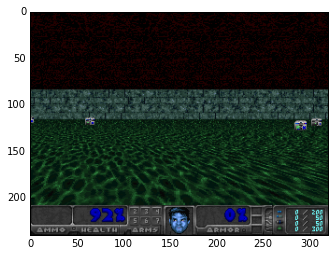

In [21]:
game.init()
game.new_episode()
state = game.get_state().screen_buffer
imgplot = plt.imshow(state)
state = preprocess_frame(state)
prob, val = sess.run([aprob, value], feed_dict={x: state.reshape(1, 84, 84, 1)})


print('Turn Right: {:4.2f}  Turn Left: {:4.2f}  Move Forward {:4.2f}'.format(prob[0][0],prob[0][2], prob[0][1]))
print('Approximated State Value: {:4.4f}'.format(val[0][0]))

### See our Agent play 🕹️

In [ ]:
# New render settings for replay
game = DoomGame()
game.load_config("health_gathering.cfg")
game.set_doom_scenario_path("health_gathering.wad")

# New render settings for replay
game.set_screen_resolution(ScreenResolution.RES_800X600)
game.set_render_hud(True)

# Replay can be played in any mode.
game.set_mode(Mode.SPECTATOR)


game.init()
i = 500


#sleep(2)

for i in range(1000):
    
    game.replay_episode("episodes/" + str(i) + "_rec.lmp")

    while not game.is_episode_finished():
        s = game.get_state()

        # Use advance_action instead of make_action.
        game.advance_action()

        r = game.get_last_reward()

    print("Episode finished.")
    print("total reward:", game.get_total_reward())
    print("************************")

game.close()